In [1]:
from google.colab import drive

drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
pip install keras

In [3]:
pip install livelossplot

In [4]:
import keras
from keras import layers
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import CSVLogger
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from livelossplot import PlotLossesKeras
import tensorflow as tf


In [5]:
#(covid + normal)
!unzip /content/gdrive/MyDrive/dataset.zip

Archive:  /content/gdrive/MyDrive/dataset.zip
   creating: dataset/Prediction/
  inflating: dataset/Prediction/NORMAL2-IM-0338-0001.jpeg  
  inflating: dataset/Prediction/NORMAL2-IM-0339-0001.jpeg  
  inflating: dataset/Prediction/NORMAL2-IM-0340-0001.jpeg  
  inflating: dataset/Prediction/NORMAL2-IM-0341-0001.jpeg  
  inflating: dataset/Prediction/NORMAL2-IM-0352-0001.jpeg  
  inflating: dataset/Prediction/NORMAL2-IM-0353-0001.jpeg  
  inflating: dataset/Prediction/NORMAL2-IM-0354-0001.jpeg  
  inflating: dataset/Prediction/NORMAL2-IM-0357-0001.jpeg  
  inflating: dataset/Prediction/NORMAL2-IM-0370-0001.jpeg  
  inflating: dataset/Prediction/NORMAL2-IM-0372-0001.jpeg  
  inflating: dataset/Prediction/NORMAL2-IM-0373-0001.jpeg  
  inflating: dataset/Prediction/NORMAL2-IM-0374-0001.jpeg  
  inflating: dataset/Prediction/ryct.2020200028.fig1a.jpeg  
  inflating: dataset/Prediction/ryct.2020200034.fig2.jpeg  
  inflating: dataset/Prediction/ryct.2020200034.fig5-day0.jpeg  
  inflating: da

In [6]:
# Data 100
training_data_dir ="dataset/train" # 80
validation_data_dir = "dataset/test" # 20

In [7]:
# Hyperparams
IMAGE_SIZE = 224
IMAGE_WIDTH, IMAGE_HEIGHT = IMAGE_SIZE, IMAGE_SIZE
EPOCHS =30
BATCH_SIZE =4
TEST_SIZE = 2
learning = 0.00001
input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, 3)

In [8]:
TRAINING_LOGS_FILE = "training_logs.csv"
MODEL_SUMMARY_FILE = "model_summary.txt"
MODEL_FILE = "model.h5"

In [9]:
#ResNet50 - Pretrained

from keras.applications.resnet50 import ResNet50
%matplotlib inline

base_model=ResNet50(weights='imagenet',include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(lr=learning, beta_1=0.9, beta_2=0.999, amsgrad=False), loss='categorical_crossentropy',metrics=['accuracy'])

import warnings
warnings.filterwarnings("ignore")

model.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
_____________________________

In [10]:
with open(MODEL_SUMMARY_FILE,"w") as fh:
    model.summary(print_fn=lambda line: fh.write(line + "\n"))

training_data_generator = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True)
validation_data_generator = ImageDataGenerator(rescale=1./255)
test_data_generator = ImageDataGenerator(rescale=1./255)

In [11]:
training_generator = training_data_generator.flow_from_directory(
    training_data_dir,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode="categorical")
validation_generator = validation_data_generator.flow_from_directory(
    validation_data_dir,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False)

Found 456 images belonging to 2 classes.
Found 80 images belonging to 2 classes.


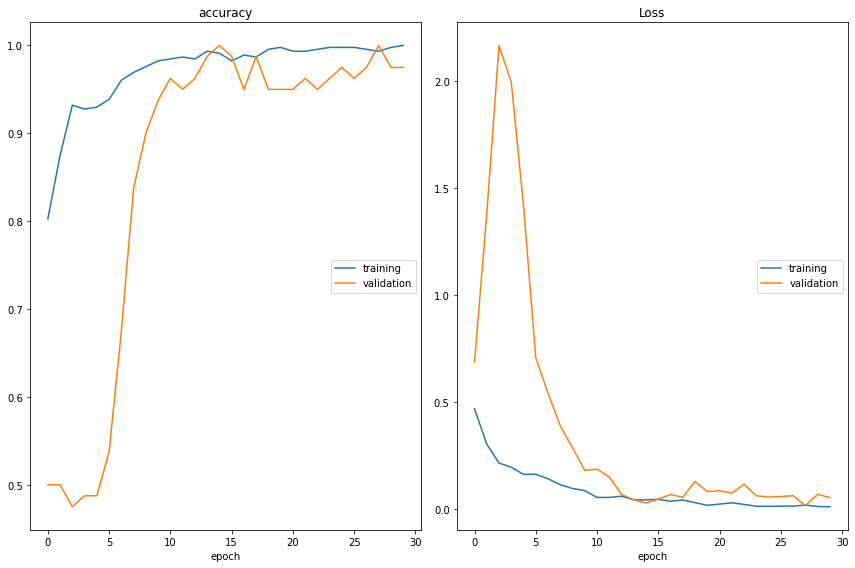

accuracy
	training         	 (min:    0.803, max:    1.000, cur:    1.000)
	validation       	 (min:    0.475, max:    1.000, cur:    0.975)
Loss
	training         	 (min:    0.010, max:    0.468, cur:    0.010)
	validation       	 (min:    0.015, max:    2.167, cur:    0.053)


In [12]:
import warnings
warnings.filterwarnings("ignore")

# Training
H = model.fit_generator(
    training_generator,
    steps_per_epoch=len(training_generator.filenames) // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=len(validation_generator.filenames) // BATCH_SIZE,
    callbacks=[PlotLossesKeras(), CSVLogger(TRAINING_LOGS_FILE,
                                            append=False,
                                            separator=";")], 
    verbose=1)

#model.save_weights(MODEL_FILE)

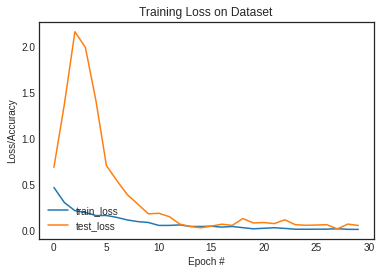

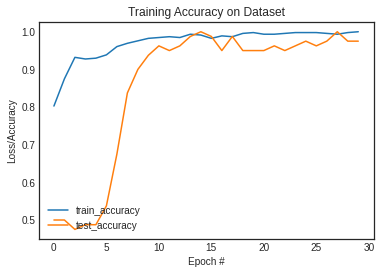

In [13]:
N = EPOCHS
plt.style.use("seaborn-white")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="test_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

plt.style.use("seaborn-white")
plt.figure()
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_accuracy")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="test_accuracy")
plt.title("Training Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

Found 80 images belonging to 2 classes.
Confusion Matrix


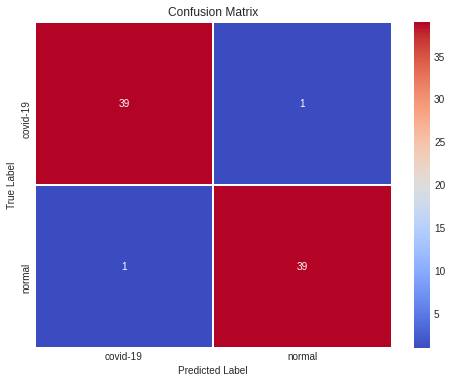

[[39  1]
 [ 1 39]]
Classification Report
              precision    recall  f1-score   support

    covid-19       0.97      0.97      0.97        40
      normal       0.97      0.97      0.97        40

    accuracy                           0.97        80
   macro avg       0.97      0.97      0.97        80
weighted avg       0.97      0.97      0.97        80



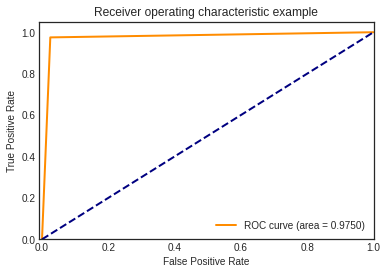

In [14]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

LABELS = ["covid-19","normal"]

def show_confusion_matrix(validations, predictions):
    matrix = confusion_matrix(validations, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix,
                cmap="coolwarm",
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt="d")
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

validation_generator = validation_data_generator.flow_from_directory(
    validation_data_dir,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False)    

filenames = validation_generator.filenames
nb_samples = len(filenames)

Y_pred = model.predict_generator(validation_generator,(nb_samples//BATCH_SIZE))
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
show_confusion_matrix(validation_generator.classes, y_pred)
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = ["covid-19","normal"]
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))
# Plot linewidth.
lw = 2
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
   fpr[i], tpr[i], _ = roc_curve(validation_generator.classes, y_pred)
   roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',
       lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [15]:
model.save("resnetmodel.h5")

In [ ]:
pip install opencv-python

In [16]:
import cv2

In [17]:
img=cv2.imread('/content/dataset/Prediction/NORMAL2-IM-0340-0001.jpeg')

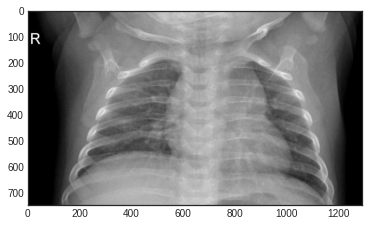

In [18]:
plt.imshow(img)

In [19]:
img=cv2.resize(img,(224,224))

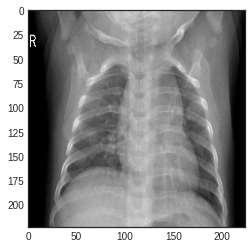

In [20]:
plt.imshow(img)

In [21]:
img_array = image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)

In [39]:
from tensorflow.keras.preprocessing import image
testimg=image.load_img("/content/dataset/Prediction/NORMAL2-IM-0372-0001.jpeg",target_size=(224, 224))
testimg=image.img_to_array(testimg)
testimg=np.expand_dims(testimg,axis=0)
testimg= testimg/255.0
result1=model.predict(testimg)
print(result1)
#print(LABELS.class_indices)

[[0.00202591 0.9979741 ]]


In [35]:
from tensorflow.keras.preprocessing import image
testimg=image.load_img("/content/dataset/Prediction/SARS-10.1148rg.242035193-g04mr34g0-Fig8c-day10.jpeg",target_size=(224, 224))
testimg=image.img_to_array(testimg)
testimg=np.expand_dims(testimg,axis=0)
testimg= testimg/255.0
result1=model.predict(testimg)
print(result1)
#print(training_set.class_indices)

[[0.9925809  0.00741909]]
